In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import random

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/masnoonnafees/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/masnoonnafees/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('moviedataset.json').read()
intents = json.loads(data_file)

In [3]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)

14 documents
3 classes ['goodbye', 'greeting', 'ratingValue']
30 unique lemmatized words [',', 'anyone', 'are', 'bye', 'chatting', 'day', 'give', 'good', 'goodbye', 'hello', 'hey', 'hi', 'hola', 'how', 'i', 'is', 'later', 'me', 'movie', 'next', 'nice', 'rating', 'review', 'see', 'there', 'till', 'time', 'to', 'want', 'you']


In [4]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [5]:
# initializing training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


/Users/masnoonnafees/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [6]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y),validation_split=0.33, epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

Train on 9 samples, validate on 5 samples
Epoch 1/200
9/9 [==============================] - 1s 131ms/sample - loss: 1.1432 - accuracy: 0.2222 - val_loss: 1.1030 - val_accuracy: 0.4000
Epoch 2/200
9/9 [==============================] - 0s 10ms/sample - loss: 1.1341 - accuracy: 0.4444 - val_loss: 1.0941 - val_accuracy: 0.2000
Epoch 3/200
9/9 [==============================] - 0s 9ms/sample - loss: 1.0710 - accuracy: 0.4444 - val_loss: 1.0835 - val_accuracy: 0.2000
Epoch 4/200
9/9 [==============================] - 0s 6ms/sample - loss: 1.0957 - accuracy: 0.3333 - val_loss: 1.0725 - val_accuracy: 0.4000
Epoch 5/200
9/9 [==============================] - 0s 6ms/sample - loss: 1.0422 - accuracy: 0.5556 - val_loss: 1.0651 - val_accuracy: 0.2000
Epoch 6/200
9/9 [==============================] - 0s 6ms/sample - loss: 1.0609 - accuracy: 0.3333 - val_loss: 1.0608 - val_accuracy: 0.2000
Epoch 7/200
9/9 [==============================] - 0s 6ms/sample - loss: 0.9790 - accuracy: 0.5556 - val_loss

9/9 [==============================] - 0s 9ms/sample - loss: 0.1060 - accuracy: 1.0000 - val_loss: 0.8963 - val_accuracy: 0.4000
Epoch 59/200
9/9 [==============================] - 0s 10ms/sample - loss: 0.0251 - accuracy: 1.0000 - val_loss: 0.8955 - val_accuracy: 0.4000
Epoch 60/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.1193 - accuracy: 1.0000 - val_loss: 0.9214 - val_accuracy: 0.4000
Epoch 61/200
9/9 [==============================] - 0s 5ms/sample - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.9423 - val_accuracy: 0.4000
Epoch 62/200
9/9 [==============================] - 0s 5ms/sample - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.9473 - val_accuracy: 0.4000
Epoch 63/200
9/9 [==============================] - 0s 5ms/sample - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.9368 - val_accuracy: 0.4000
Epoch 64/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.9361 - val_accuracy: 0.4000
Epoch 65/200
9/9 [

Epoch 116/200
9/9 [==============================] - 0s 5ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.8614 - val_accuracy: 0.4000
Epoch 117/200
9/9 [==============================] - 0s 5ms/sample - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.8740 - val_accuracy: 0.4000
Epoch 118/200
9/9 [==============================] - 0s 6ms/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.8820 - val_accuracy: 0.4000
Epoch 119/200
9/9 [==============================] - 0s 6ms/sample - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.9027 - val_accuracy: 0.4000
Epoch 120/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.9134 - val_accuracy: 0.4000
Epoch 121/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.9231 - val_accuracy: 0.4000
Epoch 122/200
9/9 [==============================] - 0s 6ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.9317 - val_accuracy: 0.4000

9/9 [==============================] - 0s 7ms/sample - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.4726 - val_accuracy: 0.4000
Epoch 174/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0220 - accuracy: 1.0000 - val_loss: 1.4843 - val_accuracy: 0.2000
Epoch 175/200
9/9 [==============================] - 0s 6ms/sample - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.4926 - val_accuracy: 0.2000
Epoch 176/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.5007 - val_accuracy: 0.2000
Epoch 177/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.5056 - val_accuracy: 0.2000
Epoch 178/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.5055 - val_accuracy: 0.2000
Epoch 179/200
9/9 [==============================] - 0s 7ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.5056 - val_accuracy: 0.2000
Epoch 180/200

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


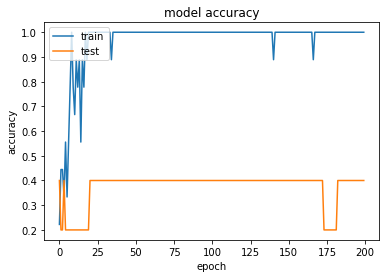

In [7]:
print(hist.history.keys())
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

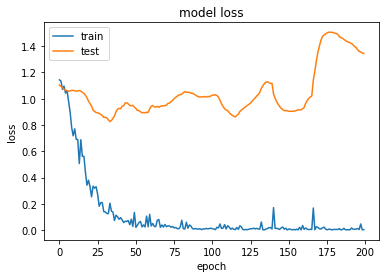

In [8]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model = Sequential()
model.add(Dense(64, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam(0.0002, 0.5)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y),validation_split=0.25, epochs=200, batch_size=10, verbose=1)
model.save('chatbot_model_lr.h5', hist)

print("model created")

Train on 10 samples, validate on 4 samples
Epoch 1/200
10/10 [==============================] - 1s 115ms/sample - loss: 1.1245 - accuracy: 0.3000 - val_loss: 1.1165 - val_accuracy: 0.2500
Epoch 2/200
10/10 [==============================] - 0s 5ms/sample - loss: 1.0880 - accuracy: 0.4000 - val_loss: 1.1129 - val_accuracy: 0.2500
Epoch 3/200
10/10 [==============================] - 0s 5ms/sample - loss: 1.0195 - accuracy: 0.6000 - val_loss: 1.1102 - val_accuracy: 0.2500
Epoch 4/200
10/10 [==============================] - 0s 5ms/sample - loss: 1.0842 - accuracy: 0.3000 - val_loss: 1.1061 - val_accuracy: 0.2500
Epoch 5/200
10/10 [==============================] - 0s 6ms/sample - loss: 0.9780 - accuracy: 0.6000 - val_loss: 1.1003 - val_accuracy: 0.2500
Epoch 6/200
10/10 [==============================] - 0s 9ms/sample - loss: 1.0761 - accuracy: 0.5000 - val_loss: 1.0951 - val_accuracy: 0.2500
Epoch 7/200
10/10 [==============================] - 0s 6ms/sample - loss: 1.0762 - accuracy: 0.4

Epoch 58/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.2723 - accuracy: 1.0000 - val_loss: 0.7164 - val_accuracy: 1.0000
Epoch 59/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.1854 - accuracy: 1.0000 - val_loss: 0.7098 - val_accuracy: 1.0000
Epoch 60/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.3110 - accuracy: 0.8000 - val_loss: 0.6999 - val_accuracy: 1.0000
Epoch 61/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.2577 - accuracy: 1.0000 - val_loss: 0.6935 - val_accuracy: 1.0000
Epoch 62/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.1557 - accuracy: 1.0000 - val_loss: 0.6865 - val_accuracy: 1.0000
Epoch 63/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.1825 - accuracy: 1.0000 - val_loss: 0.6815 - val_accuracy: 1.0000
Epoch 64/200
10/10 [==============================] - 0s 6ms/sample - loss: 0.2397 - accuracy: 1.0000 - val_loss: 0.6782 - val_accuracy:

Epoch 115/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.5267 - val_accuracy: 1.0000
Epoch 116/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0930 - accuracy: 1.0000 - val_loss: 0.5265 - val_accuracy: 1.0000
Epoch 117/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.5259 - val_accuracy: 1.0000
Epoch 118/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0788 - accuracy: 1.0000 - val_loss: 0.5244 - val_accuracy: 1.0000
Epoch 119/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.5224 - val_accuracy: 1.0000
Epoch 120/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0907 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 1.0000
Epoch 121/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.5101 - val_ac

Epoch 172/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.3946 - val_accuracy: 1.0000
Epoch 173/200
10/10 [==============================] - 0s 7ms/sample - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.3962 - val_accuracy: 1.0000
Epoch 174/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 1.0000
Epoch 175/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.3985 - val_accuracy: 1.0000
Epoch 176/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.4004 - val_accuracy: 1.0000
Epoch 177/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.4021 - val_accuracy: 1.0000
Epoch 178/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.4017 - val_ac

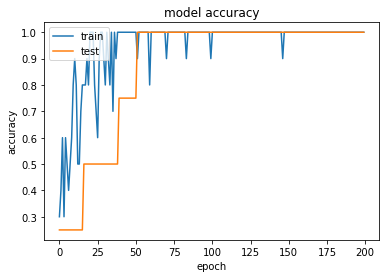

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

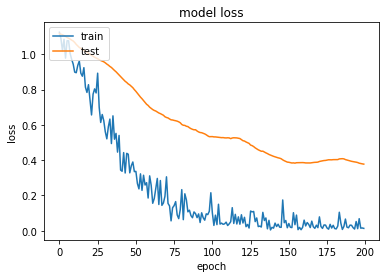

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()